#### Seyedali Shohadaeolhosseini ---- What doesn'y KILL you, makes you STRONGER

# Sentiment Analysis

In this Notebook we're going to implement an algorithm which uses Naive Bayes equation to analyse the sentiment of a tweet. 

Problem: Given a tweet, determine whether it is a positive tweet or negative one.

Procedure of this notebook:
1. We train a Naive Bayes model on a sentiment analysis task

   Procedure of its implementation:
       1. Gather data (Import dataset)
       2. Preprocess the data
           - Lower case the text
           - Remove punctuation and urls and handles
           - Remove stop words
           - Stemming or reducing words to their commen stem
           - Tokenising or splitting your document into single words/Tokens
       3. Calculation of Vocabulary and their Frequencies
       4. Calculation of Conditional Probability using the Laplacian Smoothing formula
       5. Calculation of Lambda Score
       6. Estimation of Logprior
2. We test this model
3. Error analysis
4. Predict with this model

## Step 1
Importing the required packages ... 

In [15]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

Next we import our dataset, which we have downloaded before and you can see it in this repo.

Now Let's take a look at our datasets. The below picture shows my directory containing our datasets

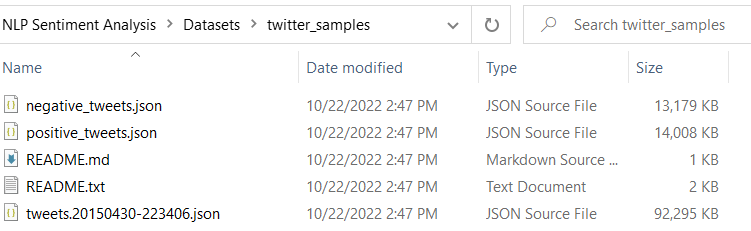

- We have imported `twitter_samples` in the last steps and in the next step we're going to import and assign  variable to it with the help of :
```python
twitter_samples.strings("name of the dataset")
```

In [41]:
AllPosTweet = twitter_samples.strings('positive_tweets.json')
AllNegTweet = twitter_samples.strings('negative_tweets.json')

Now we break the dataset into two subset, train_set and the test_set and then we combine the same categories.

Then we determine their outout class. We choose 0 for negative class and 1 for positive class. 

In [42]:
train_pos = AllPosTweet[:4000]
test_pos = AllPosTweet[4000:]

train_neg = AllNegTweet[:4000]
test_neg = AllNegTweet[4000:]

Train_X = train_pos + train_neg
Test_X = test_pos + test_neg

Train_Y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
Test_Y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

Let's check one:

In [43]:
print(Train_X[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


Now that we have imported our data we need to process each tweets. Because, each tweet consist of words and punctuation that doesn't help us in sentiment. So we need to process all of the text to have those containing meaning. To do this we have implemented below functions.

Stemming and url deleting and totally other things are processed with the help of pre-built module that nltk provided us.

In [44]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

**Dictionary building**

we will need to build a dictionary where the keys are a (word, label) tuple and the values are the corresponding frequency. Don't forget that the labels we'll use here are 1 for positive and 0 for negative. To achieve this:
1. **First**, we will implement a `freqfinder()` function that takes in the `freqs` dictionary, a word, and a label (1 or 0) and returns the number of times that word and label tuple appears in the collection of tweets.

For example: given a list of tweets `["i am rather excited", "you are rather happy"]` and the label 1, the function will return a dictionary that contains the following key-value pairs:

{
    ("rather", 1): 2
    ("happi", 1) : 1
    ("excit", 1) : 1
}

- Notice how for each word in the given string, the same label 1 is assigned to each word.
- Notice how the words "i" and "am" are not saved, since it was removed by process_tweet because it is a stopword.
- Notice how the word "rather" appears twice in the list of tweets, and so its count value is 2.

2. **Second**, we create a function `tableCreater()` that takes a list of tweets as input, cleans all of them, and returns a dictionary.
- The key in the dictionary is a tuple containing the stemmed word and its class label, e.g. ("happi",1).
- The value the number of times this word appears in the given collection of tweets (an integer).

In [45]:
def freqfinder(freqs, word, label):
    n = 0  
    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]
    return n

In [52]:
def tableCreater(tbl, tweets, ys):
    """
    Input:
        tbl: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    """
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            # define the key, which is the word and label tuple
            pair = (word, y)
            
            # if the key exists in the dictionary, increment the count
            if pair in tbl:
                tbl[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                tbl[pair] = 1    
    return tbl

### Model Training

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do you train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that you have.
- You will create a probability for each class.
    - $P(D_{pos})$ is the probability that the document is positive.
    - $P(D_{neg})$ is the probability that the document is negative.
    
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.

We can take the log of the prior to rescale it, and we'll call this the logprior:

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})$$

#### Positive and Negative Probability of a Word
To compute the positive probability and the negative probability for a specific word in the vocabulary, we'll use the following inputs:

- $freq_{pos}$ and $freq_{neg}$ are the frequencies of that specific word in the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.
- $N_{pos}$ and $N_{neg}$ are the total number of positive and negative words for all documents (for all tweets), respectively.
- $V$ is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We'll use these to compute the positive and negative probability for a specific word using this formula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}$$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}$$

Notice that we add the "+1" in the numerator for additive smoothing.  This [wiki article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations:

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

**Create `freqs` dictionary**
- Given your `tableCreater()` function, you can compute a dictionary(your table) called `freqs` that contains all the frequencies.
- In this `freqs` dictionary(table), the key is the tuple (word, label)
- The value is the number of times it has appeared.

We will use this dictionary in several parts of this assignment.

In [54]:
table = tableCreater({}, Train_X, Train_Y)

Now that we have our table ready, we can continue further to implement a naive bayes classifier.

What we should do?
- Calculate V
    - You can then compute the number of unique words that appear in the `freqs` dictionary to get your $V$ (you can use the `set` function).

- Calculate $freq_{pos}$ and $freq_{neg}$
    - Using your `freqs` dictionary, you can compute the positive and negative frequency of each word $freq_{pos}$ and $freq_{neg}$.

- Calculate $N_{pos}$ and $N_{neg}$
    - Using `freqs` dictionary, you can also compute the total number of positive words and total number of negative words $N_{pos}$ and $N_{neg}$.

- Calculate $D$, $D_{pos}$, $D_{neg}$
    - Using the `train_y` input list of labels, calculate the number of documents (tweets) $D$, as well as the number of positive documents (tweets) $D_{pos}$ and number of negative documents (tweets) $D_{neg}$.
    - Calculate the probability that a document (tweet) is positive $P(D_{pos})$, and the probability that a document (tweet) is negative $P(D_{neg})$

- Calculate the logprior
    - the logprior is $log(D_{pos}) - log(D_{neg})$

- Calculate log likelihood
    - Finally, you can iterate over each word in the vocabulary, use your `lookup` function to get the positive frequencies, $freq_{pos}$, and the negative frequencies, $freq_{neg}$, for that specific word.
    - Compute the positive probability of each word $P(W_{pos})$, negative probability of each word $P(W_{neg})$.

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V} $$

**Note:** We'll use a dictionary to store the log likelihoods for each word.  The key is the word, the value is the log likelihood of that word.

- You can then compute the loglikelihood: $log \left( \frac{P(W_{pos})}{P(W_{neg})} \right)$.

In [60]:
def trainingNaiveBayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary(tbl: Table we created) from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior.
        loglikelihood: the log likelihood of you Naive bayes equation. 
    '''
    loglikelihood = {}
    logprior = 0
    
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()]) # Set type deletes the repetitions
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += 1
        else: # else, the label is negative
            # increment the number of negative words by the count for this (word,label) pair
            N_neg += 1

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = N_pos

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = N_neg

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg) 

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
#         try:
#             freq_pos = freqs[(word, 1)]
#         except:
#             freq_pos = 0
            
#         try:
#             freq_neg = freqs[(word, 0)]
#         except:
#             freq_neg = 0
        freq_pos = freqfinder(freqs,word,1)
        freq_neg = freqfinder(freqs,word,0)
            
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log((p_w_pos/p_w_neg))

    return logprior, loglikelihood

In [62]:
logprior, loglikelihood = trainingNaiveBayes(table, Train_X, Train_Y)
print(logprior)
print(len(loglikelihood))

0.02293273898641779
9086


Until here we have trained our model. Now we must test this model with the `logprior` and `loglikelihood`, we have calculated. 

To do so, firt we implement our predictor module.

#### Implement `naive_bayes_predict`
- **Instructions**:
    Implement the `naive_bayes_predict` function to make predictions on tweets.
    * The function takes in the `tweet`, `logprior`, `loglikelihood`.
    * It returns the probability that the tweet belongs to the positive or negative class.
    * For each tweet, sum up loglikelihoods of each word in the tweet.
    * Also add the logprior to this sum to get the predicted sentiment of that tweet.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

#### Note
Note we calculate the prior from the training data, and that the training data is evenly split between positive and negative labels (4000 positive and 4000 negative tweets).  This means that the ratio of positive to negative 1, and the logprior is 0.

The value of 0.0 means that when we add the logprior to the log likelihood, we're just adding zero to the log likelihood.  However, please remember to include the logprior, because whenever the data is not perfectly balanced, the logprior will be a non-zero value.

In [66]:
def naiveBayesPredictor(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    ''' 
    
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:
        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]
    return p

In [67]:
my_tweet = 'I smiled at him. :('
p = naiveBayesPredictor(my_tweet, logprior, loglikelihood)
print('The output is', p)

The output is -5.939236147698122


#### Implement testNaiveBayes
- **Instructions**:
    * Implement `testNaiveBayes` to check the accuracy of your predictions.
    * The function takes in your `test_x`, `test_y`, log_prior, and loglikelihood
    * It returns the accuracy of your model.
    * First, use `naive_bayes_predict` function to make predictions for each tweet in text_x.

In [70]:
def testNaiveBayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naiveBayesPredictor(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = len([x for x in range(len(y_hats)) if y_hats[x] != test_y[x]])/len(test_y)

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    return accuracy

In [73]:
print("Naive Bayes accuracy = %0.4f" %
      (testNaiveBayes(Test_X, Test_Y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9955


In [78]:
for tweet in [":)", ":) :(", ':(', 'I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    p = naiveBayesPredictor(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

:) -> 6.87
:) :( -> -0.65
:( -> -7.50
I am happy -> 2.16
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.15
great great -> 4.27
great great great -> 6.39
great great great great -> 8.52


In [83]:
my_tweet = 'Your text here (; ;) :)'
naiveBayesPredictor(my_tweet, logprior, loglikelihood)

9.913647077579139

# To ADD
- Filtering words
- Error Analysis

In [84]:
## __`Done! :)`__